### Utilizando a técnica do SMOTE  

Técnica consiste em realizar um oversampling mas ao invés de multiplicar os dados existentes, cria novas amostras sintéticas com base em duas amostras próximas, como se fosse uma média entre as duas amostras.

In [1]:
#!pip install imbalanced-learn


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName('credit-card-smote').getOrCreate()

In [4]:
# carregando dataset 
df = spark.read.csv('datasets/creditcard.csv', inferSchema=True, header=True)


In [5]:
# convertendo pra pandas pq o smote so aceita pandas 
df_pd = df.select('Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class').toPandas()

# Separar as features (X) e o alvo (y)
X = df_pd[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
y = df_pd['Class']

In [6]:
# aplicando o smote no dataframe

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [7]:
# recriar o DataFrame no formato necessário, com as features e a classe
balanced_pd = pd.DataFrame(X_res, columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])
balanced_pd['Class'] = y_res
balanced_spark_df = spark.createDataFrame(balanced_pd)
balanced_spark_df.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [8]:
balanced_spark_df.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    0|284315|
|    1|284315|
+-----+------+



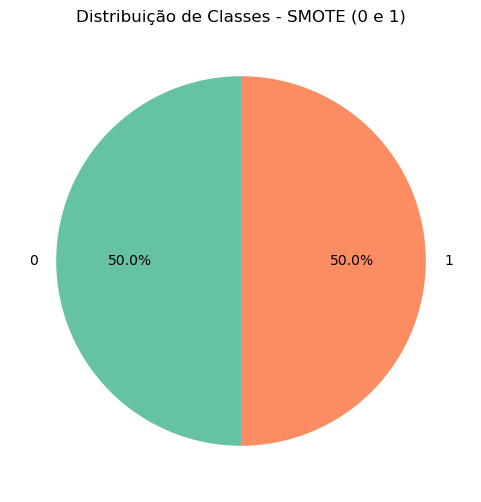

In [9]:
class_counts = balanced_spark_df.groupBy("Class").count().toPandas()
plt.figure(figsize=(6, 6))
plt.pie(class_counts['count'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title("Distribuição de Classes - SMOTE (0 e 1)")
plt.show()

In [10]:
# aplicando o vector assembler nos dados com smote 
assembler = VectorAssembler(inputCols=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'], outputCol='features')
output = assembler.transform(balanced_spark_df)
data = output.select('features', 'Class')
data.show()

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows



In [11]:
# dividindo em conjunto de treino e teste 
train, test = data.randomSplit([0.7, 0.3])

### Criação e treinamento dos modelos

In [12]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, GBTClassifier

In [13]:
lr = LogisticRegression(labelCol='Class')

In [14]:
lr_fit = lr.fit(train)
lr_sum = lr_fit.summary
lr_training = lr_sum.predictions.describe().show()

+-------+------------------+------------------+
|summary|             Class|        prediction|
+-------+------------------+------------------+
|  count|            398123|            398123|
|   mean|0.5001318687943174|0.4890875432969208|
| stddev|0.5000006105584216|0.4998815319031202|
|    min|               0.0|               0.0|
|    max|               1.0|               1.0|
+-------+------------------+------------------+



In [15]:
results = lr_fit.transform(test)
results.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|Class|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,-1.359807133...|    0|[2.22728779054856...|[0.90267334016760...|       0.0|
|[2.0,-1.158233093...|    0|[4.53175177296771...|[0.98935277606480...|       0.0|
|[4.0,1.2296576345...|    0|[3.08039444046460...|[0.95607675171549...|       0.0|
|[7.0,-0.894286082...|    0|[4.16898736421086...|[0.98476769642467...|       0.0|
|[9.0,-0.338261752...|    0|[4.28979568076853...|[0.98647763510637...|       0.0|
|[11.0,1.069373587...|    0|[1.94730832575485...|[0.87515284541227...|       0.0|
|[12.0,-0.75241704...|    0|[4.50127544401432...|[0.98902690799642...|       0.0|
|[13.0,-0.43690507...|    0|[3.70238974949729...|[0.97592918107380...|       0.0|
|[14.0,-5.40125766...|    0|[0.44810487307962...|[0.61018855618258...|       0.0|
|[26.0,-0.535387

In [16]:
rfc = RandomForestClassifier(labelCol='Class', featuresCol='features', numTrees=100)
dtc = DecisionTreeClassifier(labelCol='Class', featuresCol='features')
gbt = GBTClassifier(labelCol='Class', featuresCol='features')

In [17]:
rfc_train = rfc.fit(train)
dtc_train = dtc.fit(train)
gbt_train = gbt.fit(train)

In [18]:
rfc_preds = rfc_train.transform(test)
dtc_preds = dtc_train.transform(test)
gbt_preds = gbt_train.transform(test)

### Avaliando métricas de cada modelo

In [19]:
# avaliando a acuracia do modelo 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Logistic Regression

In [20]:
eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='accuracy')
acc = eval.evaluate(results)
print(f'Acurácia LR: {acc}')

eval = MulticlassClassificationEvaluator(labelCol='Class', predictionCol='prediction', metricName='recallByLabel')
recall = eval.evaluate(results)
print(f'Recall LR: {recall}')

Acurácia LR: 0.9807808477071323
Recall LR: 0.9916652990410991


Random Forest

In [21]:
acc_rfc = eval.evaluate(rfc_preds)
print(f'Acurácia RFC: {acc_rfc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_rfc = evaluator.evaluate(rfc_preds)
print(f"Recall RFC: {recall_rfc}")

Acurácia RFC: 0.9949007103837948
Recall RFC: 0.9949007103837948


Decision Tree

In [22]:
acc_dtc = eval.evaluate(dtc_preds)
print(f'Acurácia DTC: {acc_dtc}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_dtc = evaluator.evaluate(dtc_preds)
print(f"Recall DTC: {recall_dtc}")

Acurácia DTC: 0.984948303753546
Recall DTC: 0.984948303753546


Gradient Boosting

In [23]:
acc_gbt = eval.evaluate(gbt_preds)
print(f'Acurácia GBT: {acc_gbt}')

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="recallByLabel")
recall_gbt = evaluator.evaluate(gbt_preds)
print(f"Recall GBT: {recall_gbt}")

Acurácia GBT: 0.9906806086324526
Recall GBT: 0.9906806086324526


No caso da técnica de SMOTE, também pode gerar o overfitting, já que, como ele usa técnicas do KNN, pode acabar gerando um viés muito forte nos dados concentrados em um certo espaço, então as amostras sintéticas podem não corresponder muito bem com a minoria.